<img height="500" width="500" src="https://www.dropbox.com/s/3zsh0uy3uwmxjf2/cutting-down-tree.jpg?dl=1" />

In [1]:
from numericalunits import inch, foot, m, cm
import math

def feet_and_inches(length):    
    length_ft = length / foot
    length_floor_ft = math.floor(length_ft)
    inches_remainder = (float(length_ft) - length_floor_ft) * foot / inch
    return "{}' {:.1f}\"".format(length_floor_ft, inches_remainder)

# tree width estimation
hat_pixels = 217
tree_pixels = 290
hat_length = 11 * inch
tree_diam = tree_pixels / hat_pixels * hat_length
print("tree_diam: {}".format(feet_and_inches(tree_diam)))
bark_depth = 2 * inch
hardwood_diam = tree_diam - 2 * bark_depth
print("hardwood_diam: {}".format(feet_and_inches(hardwood_diam)))
hardwood_radius = hardwood_diam / 2

flooring_length = 12 * foot
flooring_depth = 1 * inch
flooring_min_width = 4 * inch # mbar floors = 2 * inch
cut_kerf = 1/8 * inch
flooring_layer = flooring_depth + cut_kerf

tree_diam: 1' 2.7"
hardwood_diam: 0' 10.7"


![depth image](https://www.dropbox.com/s/22bv339sxk1lz35/depth-width-diagram.png?dl=1)

In [2]:
from sympy import *
import numpy as np

d, s, w, r = symbols("d s w r")
eq1 = Eq(r, sqrt(s**2 + (w/2)**2))
eq2 = eq1.subs(s, r - d)
eq_w = solve(eq2, w)[0]
print(eq_w)

2*sqrt(d*(-d + 2*r))


\begin{equation}
board\ width = \textbf{floor} \left(2 \sqrt{2 d r - d^2} \right)
\end{equation}

In [3]:
eq3 = eq_w.subs(r, hardwood_radius)
board_width_at_depth = lambdify(d, eq3, "numpy")
board_width_at_depth_inches = lambda d_v: np.floor(board_width_at_depth(d_v * inch) / inch)
board_width_at_depth_inches(1)

6.0

In [4]:
depths = np.arange(flooring_layer/inch, hardwood_diam/inch, flooring_layer/inch)
widths = board_width_at_depth_inches(depths)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def round_down_to_even(v):
    return int(v - v % 2)

def nice_even_range(values):
    spacing = 2
    min_value = round_down_to_even(min(values)) - spacing      # pad bottom
    max_value = round_down_to_even(max(values)) + 2 * spacing  # pad top; also range is exclusive
    return list(range(min_value, max_value, spacing))

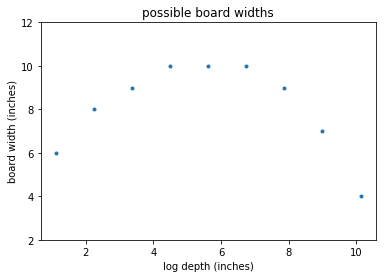

In [6]:
plt.plot(depths, widths, '.')
plt.title('possible board widths')
plt.xlabel('log depth (inches)')
plt.ylabel('board width (inches)')
plt.yticks(nice_even_range(widths));

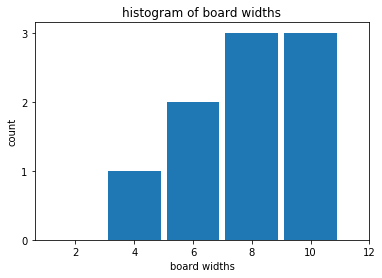

In [7]:
bins = nice_even_range(widths)
histogram = plt.hist(widths, bins=bins, rwidth=0.9, align='left')
plt.title('histogram of board widths')
plt.xlabel('board widths')
plt.ylabel('count')
plt.xticks(bins);
bin_values = histogram[0]
max_bin_value = int(max(bin_values))
plt.yticks(range(1 + max_bin_value));

In [8]:
print("assuming\n------")
print("tree_diam\t{}".format(feet_and_inches(tree_diam)))
print("hardwood_radius\t{}".format(feet_and_inches(hardwood_diam)))

print("\nwe could mill\n------")
board_count = len(widths)
print("board count\t%d" % (board_count))

stacked_width_feet = np.sum(widths) * inch / foot
print("stacked width\t%0.1f'" % (stacked_width_feet))

total_square_feet = flooring_length / foot * stacked_width_feet
print("square feet\t%d" % (total_square_feet))


milled_length = board_count * flooring_length

class Calculator:
    prices = {}
    total = 0

    def add_price(self, thing, per_unit, units):
        price = per_unit * units
        self.prices[thing] = price
        self.total += price
    
    def report(self):
        for k, v in self.prices.items():
            print("%s\t\t$%d" % (k, v))

        print('---------------------')
        print("total\t\t$%d" % (self.total))

calc = Calculator()
calc.add_price('lumber', 0.3 / foot,  milled_length)
calc.add_price('kilm', 0.3 / foot,  milled_length)
calc.add_price('planing', 0.5,  total_square_feet)
calc.add_price('transit', 300,  1)
print("\ncost\n------")
calc.report()

assuming
------
tree_diam	1' 2.7"
hardwood_radius	0' 10.7"

we could mill
------
board count	9
stacked width	6.1'
square feet	73

cost
------
lumber		$32
kilm		$32
planing		$36
transit		$300
---------------------
total		$401
